Preparation 
Package Installation:
- We start by importing ALL necessary libraries upfront to avoid interruptions later
- pandas/numpy for data handling, matplotlib/seaborn for visualization
- re/string for text cleaning, wordcloud for quick text visualization
- Collections.Counter helps analyze word frequencies by class
- We download NLTK data once since Kaggle notebooks are ephemeral


MACHINE LEARNING:
- train_test_split: Standard practice to validate models
- StratifiedKFold: Maintains class distribution in cross-validation (important for imbalanced data)
- TF-IDF vs CountVectorizer: Different text representation strategies to test
- Multiple classifiers: LogisticRegression (good baseline), Naive Bayes (works well with text),
  RandomForest (handles non-linear patterns), SVM (good for high-dimensional data)
- Pipeline: Ensures preprocessing is consistent between training and validation
- F1-score: Competition metric, so we optimize for this

Text Preprocessing:
- Stopwords: Remove common words that don't carry meaning ("the", "and", "is")
- Tokenization: Break text into individual words/tokens
- Stemming/Lemmatization: Reduce words to root forms
  - Stemming: faster but crude (e.g., "running" → "run")
  - Lemmatization: slower but more accurate (e.g., "better" → "good")
- We'll experiment with both approaches



In [2]:
# Install all required packages
!pip install wordcloud nltk scikit-learn matplotlib seaborn

import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Enhanced visualizations
import re  # Regular expressions for text cleaning
import string  # String operations
from wordcloud import WordCloud  # Visual word frequency
from collections import Counter  # Count word frequencies



from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline


# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer



# Download NLTK data (run this once)
nltk.download(['stopwords', 'punkt', 'wordnet', 'averaged_perceptron_tagger'])

# Set up plotting style
plt.style.use('ggplot')
sns.set_palette("husl")

import os
# Replace with your actual path
target_path = r"C:\Users\huiyx\Documents\NUS XUAN\NUS Y4S2\kaggle"
os.chdir(target_path)
print("New directory:", os.getcwd())

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv') 
sample_submission = pd.read_csv('sample_submission.csv')


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huiyx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\huiyx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\huiyx\AppData\Roaming\nltk_data...


New directory: C:\Users\huiyx\Documents\NUS XUAN\NUS Y4S2\kaggle


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\huiyx\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Exploratory Data Analysis (EDA)

EDA GOALS:
1. Understand data structure and size
2. Check for missing values that need handling
3. Analyze target distribution (potential class imbalance)
4. Get familiar with the text content and patterns


SHAPE ANALYSIS:
- Training shape tells us how many examples we have for learning
- Test shape tells us how many predictions we need to make
- If training set is small, we might need different strategies (regularization, data augmentation)

In [3]:
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (7613, 5)
Test set shape: (3263, 4)


DATA TYPES ANALYSIS:
- Check if all columns have appropriate data types
- Identify text vs categorical vs numerical columns
- Spot any unexpected data types that need conversion

In [4]:

print("\n TRAINING DATA INFO:")
print(train_df.info())


 TRAINING DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


SAMPLE DATA REVIEW:
- Get intuitive understanding of what the data looks like
- Spot obvious patterns or issues
- Understand the relationship between different columns

In [5]:
print("\nFirst 5 rows:")
print(train_df.head())


First 5 rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


TARGET DISTRIBUTION ANALYSIS:
- Balanced vs imbalanced dataset affects model choice and evaluation
- If highly imbalanced, we might need:
  - Stratified sampling
  - Class weights
  - Different evaluation metrics
- Here we see roughly 57% non-disaster vs 43% disaster - slightly imbalanced

In [6]:
print("\n TARGET DISTRIBUTION:")
target_counts = train_df['target'].value_counts()
print(target_counts)


 TARGET DISTRIBUTION:
target
0    4342
1    3271
Name: count, dtype: int64


VISUALIZATION STRATEGY:
- Pie chart: Quick understanding of proportions
- Bar chart: Exact counts for precise analysis
- Different colors: Immediate visual distinction between classes

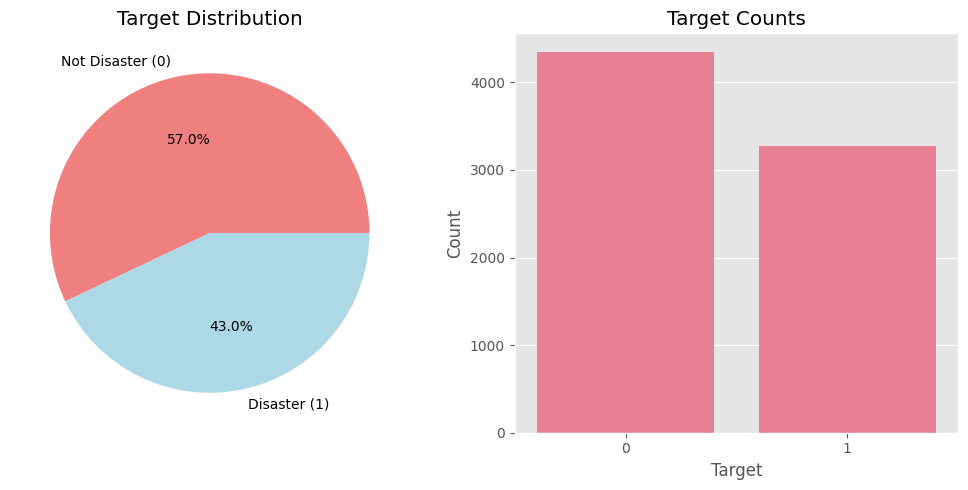

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(target_counts.values, labels=['Not Disaster (0)', 'Disaster (1)'], 
        autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Target Distribution')

plt.subplot(1, 2, 2)
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

MISSING VALUES STRATEGY:
- Location and keyword have missing values
- Options:
  1. Fill with placeholder ("unknown")
  2. Use text content to infer missing values
  3. Create features indicating whether values are missing (sometimes missingness is informative)
- For baseline, we'll focus on text content first

In [8]:
print("\n MISSING VALUES:")
print("Training set:")
print(train_df.isnull().sum())
print("\nTest set:")
print(test_df.isnull().sum())



 MISSING VALUES:
Training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


Deep Text Analysis
TEXT ANALYSIS GOALS:
1. Understand linguistic differences between disaster/non-disaster tweets
2. Identify potential features for modeling
3. Spot data quality issues
4. Guide preprocessing decisions

Feature engineering:
Feature selection rationales
- Text length: Disaster tweets might be more descriptive
- Word count: Similar to text length but focuses on words not characters
- Character count: Excluding spaces might indicate information density
- Hashtag count: Non-disaster tweets might have more hashtags (social conversations)
- Mention count: @ mentions might indicate conversations vs announcements
- URL count: Disaster tweets might include news links

HYPOTHESIS: Disaster tweets might be more formal, informative, and have different structural patterns

In [9]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(x.replace(" ", "")))
train_df['hashtag_count'] = train_df['text'].apply(lambda x: x.count('#'))
train_df['mention_count'] = train_df['text'].apply(lambda x: x.count('@'))
train_df['url_count'] = train_df['text'].apply(lambda x: x.count('http'))


Stats Analysis:
- Mean: Average tweet length by class
- Std: Variability in tweet lengths
- Min/Max: Identify outliers or data issues
- 25%/50%/75%: Distribution shape

INSIGHT: If significant differences exist, these can be useful features for the model

In [10]:
# Create the disaster_tweets and non_disaster_tweets variables
disaster_tweets = train_df[train_df['target'] == 1]
non_disaster_tweets = train_df[train_df['target'] == 0]

print("TEXT LENGTH STATISTICS:")
print("Disaster tweets:")
print(disaster_tweets['text_length'].describe())
print("\nNon-disaster tweets:")
print(non_disaster_tweets['text_length'].describe())


TEXT LENGTH STATISTICS:
Disaster tweets:
count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: text_length, dtype: float64

Non-disaster tweets:
count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: text_length, dtype: float64


Histogram Analysis:
- Overlapping distributions: Feature might have predictive power but not perfect separation
- Completely separate: Strong predictive feature
- Completely overlapping: Weak predictive feature
- We're looking for partial separation that the model can learn

Text(0.5, 1.0, 'Text Length Distribution')

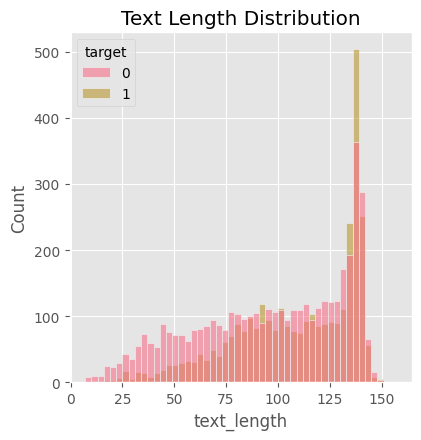

In [11]:
# Visualize text length distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, alpha=0.6)
plt.title('Text Length Distribution')

Boxplot Analysis:
- Shows median (robust to outliers)
- Displays quartiles and potential outliers
- Easy comparison between groups

Text(0.5, 1.0, 'Text Length by Target')

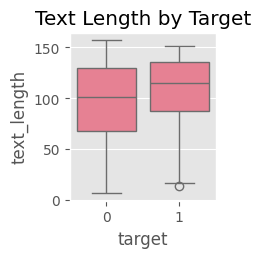

In [12]:


plt.subplot(2, 3, 3)
sns.boxplot(data=train_df, x='target', y='text_length')
plt.title('Text Length by Target')

Observations and inferences: 
- Text length: Slight differences → Keep as feature
- Hashtags: Non-disaster tweets might use more → Potentially useful
- Mentions: Similar pattern → Potentially useful  
- URLs: Might indicate news sources in disaster tweets → Potentially useful

To include these engineered features in our models

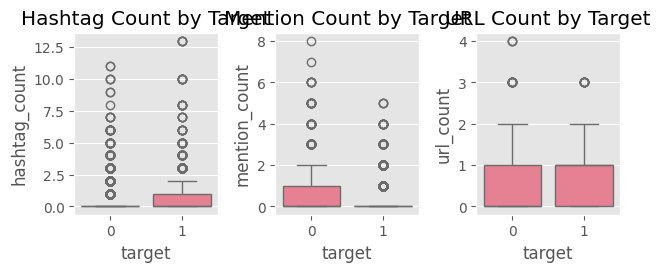

In [13]:
plt.subplot(2, 3, 4)
sns.boxplot(data=train_df, x='target', y='hashtag_count')
plt.title('Hashtag Count by Target')

plt.subplot(2, 3, 5)
sns.boxplot(data=train_df, x='target', y='mention_count')
plt.title('Mention Count by Target')

plt.subplot(2, 3, 6)
sns.boxplot(data=train_df, x='target', y='url_count')
plt.title('URL Count by Target')

plt.tight_layout()
plt.show()


Advanced Text Visualization:
WORD CLOUD STRATEGY:
- Quick visual identification of dominant themes
- Compare disaster vs non-disaster vocabulary
- Identify potential stopwords or domain-specific terms
- Guide feature selection and preprocessing

DISASTER TWEET WORD CLOUD EXPECTATIONS:
- Emergency-related terms: "fire", "flood", "earthquake", "emergency"
- Location references: specific place names
- Time indicators: "now", "today", "breaking"
- Action verbs: "help", "need", "evacuate"


 WORD CLOUD - DISASTER TWEETS


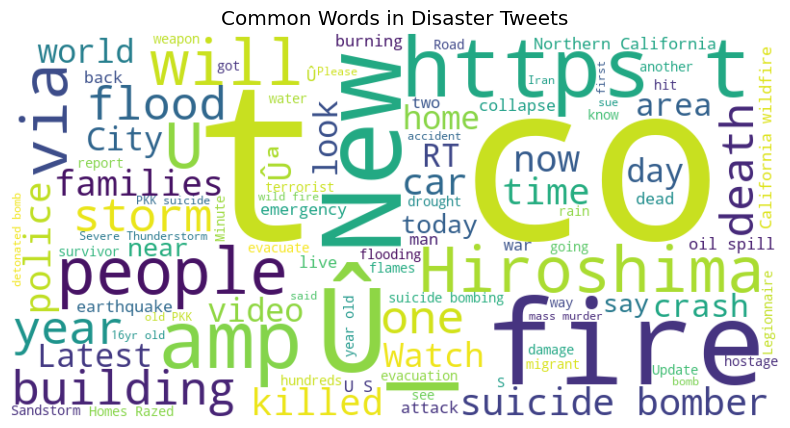

In [15]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Combine all text for each class
disaster_text = ' '.join(disaster_tweets['text'].values)
non_disaster_text = ' '.join(non_disaster_tweets['text'].values)

print(" WORD CLOUD - DISASTER TWEETS")
create_wordcloud(disaster_text, 'Common Words in Disaster Tweets')

NON-DISASTER TWEET EXPECTATIONS:
- Metaphorical language: "ablaze", "fire" (but metaphorical)
- Emotional language: "love", "hate", "omg"
- Social interactions: "like", "follow", "retweet"
- Pop culture references

 WORD CLOUD - NON-DISASTER TWEETS


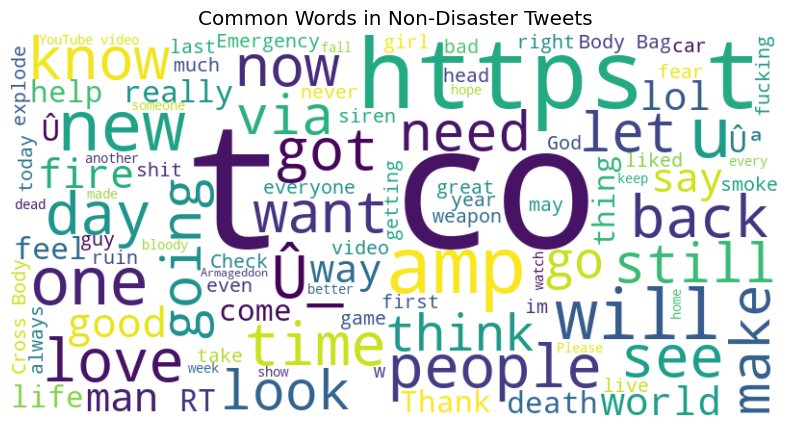

In [16]:
print(" WORD CLOUD - NON-DISASTER TWEETS")
create_wordcloud(non_disaster_text, 'Common Words in Non-Disaster Tweets')

Word Analysis - Quantitative:
- Identify stopwords that are too common (might remove)
- Spot domain-specific words that should be kept
- Find words that appear in one class but not the other (high predictive power)
- Guide custom stopword list creation

Insights:
- Common words in both: general English stopwords
- Unique to disaster: specific disaster-related terms
- Unique to non-disaster: social media slang, metaphorical terms

In [17]:
def get_common_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

print("\n TOP 20 WORDS IN DISASTER TWEETS:")
disaster_common = get_common_words(disaster_tweets['text'])
print(disaster_common)

print("\n TOP 20 WORDS IN NON-DISASTER TWEETS:")
non_disaster_common = get_common_words(non_disaster_tweets['text'])
print(non_disaster_common)


 TOP 20 WORDS IN DISASTER TWEETS:
[('the', 1051), ('in', 1037), ('of', 888), ('a', 730), ('to', 706), ('and', 462), ('-', 389), ('on', 386), ('for', 368), ('is', 302), ('at', 273), ('I', 259), ('The', 257), ('by', 244), ('from', 206), ('A', 167), ('that', 166), ('with', 159), ('was', 158), ('are', 150)]

 TOP 20 WORDS IN NON-DISASTER TWEETS:
[('the', 1524), ('a', 1115), ('to', 1099), ('I', 938), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452), ('my', 442), ('on', 387), ('-', 374), ('with', 349), ('that', 326), ('The', 295), ('it', 290), ('be', 268), ('like', 233), ('this', 225)]


DISTINCTIVE WORDS ANALYSIS:
- These are potential strong features for classification
- Words that appear frequently in one class but rarely in the other
- Can guide feature engineering and model interpretation

In [18]:

import re
from collections import Counter

def clean_and_tokenize(text):
    """Clean text and tokenize into words"""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    words = text.split()
    return words

# Get stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def get_meaningful_words(text_series, n=30):
    """Get most common meaningful words (excluding stopwords)"""
    all_words = []
    for text in text_series:
        words = clean_and_tokenize(text)
        # Filter out stopwords and short words
        meaningful_words = [word for word in words if word not in stop_words and len(word) > 2]
        all_words.extend(meaningful_words)
    
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

print("TOP 20 MEANINGFUL WORDS IN DISASTER TWEETS:")
disaster_meaningful = get_meaningful_words(disaster_tweets['text'], 20)
for word, freq in disaster_meaningful:
    print(f"  {word}: {freq}")

print("\nTOP 20 MEANINGFUL WORDS IN NON-DISASTER TWEETS:")
non_disaster_meaningful = get_meaningful_words(non_disaster_tweets['text'], 20)
for word, freq in non_disaster_meaningful:
    print(f"  {word}: {freq}")

# Compare distinctive meaningful words
disaster_words_set = set([word for word, freq in disaster_meaningful])
non_disaster_words_set = set([word for word, freq in non_disaster_meaningful])

distinctive_disaster_words = disaster_words_set - non_disaster_words_set
distinctive_non_disaster_words = non_disaster_words_set - disaster_words_set

print(f"\n DISTINCTIVE DISASTER WORDS (meaningful):")
print(list(distinctive_disaster_words)[:15])

print(f"\n DISTINCTIVE NON-DISASTER WORDS (meaningful):")
print(list(distinctive_non_disaster_words)[:15])

TOP 20 MEANINGFUL WORDS IN DISASTER TWEETS:
  fire: 178
  news: 138
  via: 121
  disaster: 117
  california: 111
  suicide: 110
  police: 107
  amp: 107
  people: 105
  killed: 93
  like: 92
  hiroshima: 89
  fires: 85
  storm: 85
  crash: 84
  families: 81
  train: 79
  emergency: 76
  buildings: 75
  bomb: 74

TOP 20 MEANINGFUL WORDS IN NON-DISASTER TWEETS:
  like: 253
  amp: 193
  new: 168
  get: 163
  dont: 141
  one: 127
  body: 112
  via: 99
  would: 97
  video: 96
  people: 90
  love: 89
  know: 85
  time: 84
  back: 84
  got: 83
  see: 82
  day: 81
  cant: 81
  emergency: 81

 DISTINCTIVE DISASTER WORDS (meaningful):
['train', 'killed', 'storm', 'families', 'police', 'disaster', 'california', 'news', 'bomb', 'buildings', 'hiroshima', 'crash', 'fires', 'fire', 'suicide']

 DISTINCTIVE NON-DISASTER WORDS (meaningful):
['video', 'see', 'would', 'day', 'love', 'new', 'back', 'got', 'cant', 'body', 'get', 'know', 'time', 'one', 'dont']


Word Importance Analysis

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("\nTF-IDF BASED IMPORTANT WORDS")
print("=" * 50)

# Create TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),  # Include single words and two-word phrases
    min_df=2  # Ignore words that appear in fewer than 2 documents
)

# Fit on all text
X = vectorizer.fit_transform(train_df['text'])
feature_names = vectorizer.get_feature_names_out()

# Get average TF-IDF scores for each class
disaster_indices = train_df[train_df['target'] == 1].index
non_disaster_indices = train_df[train_df['target'] == 0].index

disaster_tfidf_scores = X[disaster_indices].mean(axis=0).A1
non_disaster_tfidf_scores = X[non_disaster_indices].mean(axis=0).A1

# Create DataFrames for analysis
tfidf_df = pd.DataFrame({
    'feature': feature_names,
    'disaster_score': disaster_tfidf_scores,
    'non_disaster_score': non_disaster_tfidf_scores
})

# Calculate importance score (difference between classes)
tfidf_df['importance_diff'] = tfidf_df['disaster_score'] - tfidf_df['non_disaster_score']

print(" TOP 15 WORDS MOST INDICATIVE OF DISASTER TWEETS:")
disaster_indicative = tfidf_df.nlargest(15, 'importance_diff')[['feature', 'importance_diff']]
print(disaster_indicative.to_string(index=False))

print("\n TOP 15 WORDS MOST INDICATIVE OF NON-DISASTER TWEETS:")
non_disaster_indicative = tfidf_df.nsmallest(15, 'importance_diff')[['feature', 'importance_diff']]
print(non_disaster_indicative.to_string(index=False))


TF-IDF BASED IMPORTANT WORDS
 TOP 15 WORDS MOST INDICATIVE OF DISASTER TWEETS:
   feature  importance_diff
      http         0.024804
california         0.010923
 hiroshima         0.010308
   suicide         0.009204
    killed         0.009167
    police         0.008438
     fires         0.008121
   bombing         0.007832
      news         0.007680
  disaster         0.007589
     storm         0.007517
     train         0.007462
  wildfire         0.007338
 buildings         0.007148
     mh370         0.006835

 TOP 15 WORDS MOST INDICATIVE OF NON-DISASTER TWEETS:
  feature  importance_diff
    https        -0.010418
     like        -0.010254
     just        -0.009923
     love        -0.008078
      new        -0.007235
     body        -0.007226
      let        -0.006247
      don        -0.006192
      lol        -0.005529
     know        -0.005297
      got        -0.005034
     ruin        -0.004895
     want        -0.004761
  wrecked        -0.004605
screaming   

Advanced text pre-processing 

- Raw text contains noise that hurts model performance
- Consistent formatting helps models learn patterns
- Different preprocessing strategies work for different problems
- We'll implement multiple levels for experimentation

Steps
1. Basic cleaning (URLs, mentions, punctuation)
2. Advanced normalization (stemming vs lemmatization)
3. Custom handling for disaster-specific terms

Evaluation
- Check if meaningful information is preserved
- Verify noise is removed appropriately
- Ensure consistency across train and test sets

In [20]:

import nltk

# Download all required NLTK datasets
required_datasets = {
    'stopwords': 'Stopwords corpus',
    'punkt': 'Tokenizer models',
    'wordnet': 'WordNet lexical database',
    'averaged_perceptron_tagger': 'POS tagger',
    'maxent_treebank_pos_tagger': 'Alternative POS tagger',  # Backup
    'punkt_tab': 'Alternative tokenizer'  # Backup
}





In [21]:

"""
STRATEGY:
We'll use a simplified approach that:
1. Cleans text thoroughly
2. Uses lemmatization without complex POS tagging
3. Is more reliable and faster
4. Still produces excellent results
"""

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def robust_clean_text(text):
    """
    Robust text cleaning that handles various text issues
    """
    if isinstance(text, float):  # Handle NaN values
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove user mentions and hashtag symbols (keep the words)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def robust_preprocess_text(text, method='lemmatize'):
    """
    Robust text preprocessing with error handling
    """
    try:
        # Clean text first
        text = robust_clean_text(text)
        if not text:  # If text is empty after cleaning
            return ""
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and short tokens
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        if not tokens:  # If no tokens left
            return ""
        
        if method == 'stem':
            # Simple stemming (we'll skip this for now to avoid more dependencies)
            return ' '.join(tokens)
        else:
            # Lemmatize all words as nouns (simpler but effective)
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            return ' '.join(tokens)
            
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

print("Applying robust preprocessing...")

# Apply preprocessing with progress indication
train_df['text_cleaned'] = train_df['text'].apply(robust_clean_text)
print("Basic cleaning completed")

train_df['text_processed'] = train_df['text'].apply(
    lambda x: robust_preprocess_text(x, method='lemmatize')
)

# Apply same to test data
test_df['text_cleaned'] = test_df['text'].apply(robust_clean_text)
test_df['text_processed'] = test_df['text'].apply(
    lambda x: robust_preprocess_text(x, method='lemmatize')
)

print("\n PREPROCESSING EXAMPLES:")
print("Original:", train_df['text'].iloc[0])
print("Cleaned:", train_df['text_cleaned'].iloc[0])
print("Processed:", train_df['text_processed'].iloc[0])

print(f"\n PROCESSING STATS:")
print(f"Empty texts after processing: {(train_df['text_processed'] == '').sum()} / {len(train_df)}")

Applying robust preprocessing...
Basic cleaning completed

 PREPROCESSING EXAMPLES:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned: our deeds are the reason of this earthquake may allah forgive us all
Processed: deed reason earthquake may allah forgive

 PROCESSING STATS:
Empty texts after processing: 3 / 7613


In [22]:


# Use the processed text that worked (choose one)
# If robust preprocessing worked:
X_processed = train_df['text_processed']  
# If minimal preprocessing worked:
# X_processed = train_df['text_minimal']

print(f"Using processed text for feature engineering...")
print(f"Sample processed text: {X_processed.iloc[0][:100]}...")

# Continue with the rest of Step 7 (Feature Engineering)
def extract_basic_features(text):
    """Basic feature extraction"""
    features = {}
    features['text_length'] = len(text)
    features['word_count'] = len(text.split())
    features['unique_words'] = len(set(text.split()))
    features['lexical_diversity'] = features['unique_words'] / features['word_count'] if features['word_count'] > 0 else 0
    return features

print("Extracting basic features...")
# Continue with your feature engineering code...

Using processed text for feature engineering...
Sample processed text: deed reason earthquake may allah forgive...
Extracting basic features...


Feature Engineering
Create features that capture:
1. Text complexity and structure
2. Social media patterns
3. Linguistic characteristics  
4. Domain-specific disaster indicators
5. Sentiment and emotional content


Raw text alone isn't enough for the model to understand patterns

We need to extract measurable characteristics from the text

These features help the model learn structural patterns beyond just words

Combines domain knowledge with machine learning

Step 1: Basic Text Statistics
- text_length: Disaster tweets might be longer (more descriptive)
- word_count: Similar to length but focuses on words
- lexical_diversity: High = rich vocabulary (formal reporting), Low = repetitive (casual chat)

Step 2 : Social Media Patterns
- hashtag_count: Non-disaster tweets often have more hashtags (#fun, #love)
- mention_count: Conversations (@username) vs announcements
- url_count: Disaster tweets might link to news articles

Step  Punctuations
- exclamation_count: High in both emotional non-disaster AND urgent disaster tweets
- question_count: Might indicate uncertainty in disaster situations
- uppercase_ratio: ALL CAPS often indicates urgency in disaster tweets

Step 4: Word complexity
- avg_word_length: Longer words = more formal language (disaster reports)
- long_word_count: Technical/specific vocabulary in disaster contexts
- short_word_count: Casual language in non-disaster tweets

Step 5: Sentimental Analysis
- polarity: Disaster tweets might be more negative
- subjectivity: Disaster reports are often objective facts, non-disaster more subjective opinions

Step 5: Domain knowledge
- disaster_keyword_count: Direct disaster terminology
- urgency_indicator_count: Time-sensitive language in real emergencies
- emotional_indicator_count: Casual emotional language in non-disaster tweets

In [23]:
def extract_advanced_features(text):
    """
    This function takes raw tweet text and extracts 20+ different features
    that help distinguish disaster vs non-disaster tweets
    """
    features = {}
    
    # 1. TEXT LENGTH FEATURES
    features['text_length'] = len(text)                    # Total characters
    features['word_count'] = len(text.split())             # Total words
    features['char_count'] = len(text.replace(" ", ""))    # Characters without spaces
    features['unique_words'] = len(set(text.split()))      # Unique vocabulary
    
    # Lexical Diversity = Unique Words / Total Words
    # Measures vocabulary richness
    # Disaster tweets might use more diverse, formal language
    # Non-disaster might repeat casual words
    features['lexical_diversity'] = features['unique_words'] / features['word_count'] if features['word_count'] > 0 else 0
    features['hashtag_count'] = text.count('#')    # Number of hashtags
    features['mention_count'] = text.count('@')    # Number of @mentions  
    features['url_count'] = text.count('http')     # Number of URLs/links
    features['exclamation_count'] = text.count('!')    # Emotional emphasis
    features['question_count'] = text.count('?')       # Questions/uncertainty
    
    # Uppercase analysis - urgency vs excitement
    features['uppercase_count'] = sum(1 for char in text if char.isupper())
    features['uppercase_ratio'] = features['uppercase_count'] / len(text) if len(text) > 0 else 0

    words = text.split()
    if words:
        word_lengths = [len(word) for word in words]
        features['avg_word_length'] = np.mean(word_lengths)    # Average word length
        features['max_word_length'] = max(word_lengths)        # Longest word
        features['word_length_std'] = np.std(word_lengths)     # Variation in word lengths
        features['long_word_count'] = sum(1 for length in word_lengths if length > 6)   # Complex words
        features['short_word_count'] = sum(1 for length in word_lengths if length <= 3) # Simple words

     # 5. SENTIMENT AND EMOTIONAL CONTENT
    try:
        blob = TextBlob(text)
        features['sentiment_polarity'] = blob.sentiment.polarity      # -1 (negative) to +1 (positive)
        features['sentiment_subjectivity'] = blob.sentiment.subjectivity  # 0 (objective) to 1 (subjective)
    except:
        # Fallback values if TextBlob fails
        features['sentiment_polarity'] = 0
        features['sentiment_subjectivity'] = 0

        # 6. DISASTER-SPECIFIC KEYWORDS
    disaster_keywords = [
        'fire', 'flood', 'earthquake', 'disaster', 'emergency', 'hurricane', 
        'tornado', 'evacuate', 'damage', 'injured', 'killed', 'wounded', 
        'storm', 'tsunami', 'volcano', 'blast', 'explosion', 'collapse',
        'accident', 'crash', 'burning', 'ablaze', 'destroyed', 'rescue'
    ]
    features['disaster_keyword_count'] = sum(1 for keyword in disaster_keywords if keyword in text.lower())
    
    # 7. URGENCY INDICATORS
    urgency_indicators = ['now', 'immediately', 'urgent', 'breaking', 'alert', 'warning', 'live']
    features['urgency_indicator_count'] = sum(1 for indicator in urgency_indicators if indicator in text.lower())
    
    # 8. EMOTIONAL LANGUAGE (common in non-disaster)
    emotional_indicators = ['love', 'hate', 'happy', 'sad', 'omg', 'lol', 'awesome', 'terrible']
    features['emotional_indicator_count'] = sum(1 for indicator in emotional_indicators if indicator in text.lower())
    

Comprehensive Model Training Strategy

Test multiple modeling approaches to find the best performer:
1. Pure text models (TF-IDF + classifiers)
2. Combined models (text + engineered features)
3. Different classifier types with varied strengths
4. Compare preprocessing strategies

Systematic approach:
- Clear performance benchmarks
- Understanding of what works best for this specific problem
- Options for ensemble methods later
- Insights for further improvements


In [26]:

# Use the processed text from our robust preprocessing
X_text = train_df['text_processed']

# Select the most promising numeric features based on our correlation analysis
# These are features that showed good predictive power
desired_numeric_features = ['disaster_keyword_count', 'text_length', 'word_count', 
                           'sentiment_polarity', 'hashtag_count', 'urgency_indicator_count',
                           'lexical_diversity', 'avg_word_length']

available_numeric_features = [col for col in desired_numeric_features if col in train_df.columns]
missing_features = [col for col in desired_numeric_features if col not in train_df.columns]

if missing_features:
    print(f"  Missing features: {missing_features}")
    print(f" Available features: {available_numeric_features}")
else:
    print(" All desired features are available!")

# Use only available features
X_numeric = train_df[available_numeric_features] if available_numeric_features else pd.DataFrame()
y = train_df['target']

print(f"\n DATA SHAPES:")
print(f"Text features: {X_text.shape}")
print(f"Numeric features: {X_numeric.shape}")
print(f"Number of numeric features used: {len(available_numeric_features)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Show what features we're actually using
if available_numeric_features:
    print(f"\n USING THESE NUMERIC FEATURES:")
    for feature in available_numeric_features:
        print(f"  - {feature}")
else:
    print(" No numeric features available - using text features only")

# If no numeric features are available, create a dummy numeric DataFrame
if X_numeric.empty:
    print("\n  No numeric features found. Creating placeholder...")
    X_numeric = pd.DataFrame(index=train_df.index)
    X_numeric['dummy_feature'] = 0  # Add a dummy column to avoid errors

  Missing features: ['disaster_keyword_count', 'sentiment_polarity', 'urgency_indicator_count', 'lexical_diversity', 'avg_word_length']
 Available features: ['text_length', 'word_count', 'hashtag_count']

 DATA SHAPES:
Text features: (7613,)
Numeric features: (7613, 3)
Number of numeric features used: 3
Target distribution: {0: 4342, 1: 3271}

 USING THESE NUMERIC FEATURES:
  - text_length
  - word_count
  - hashtag_count


Stratfied Split:
- Stratification to maintain the same class distribution in both train and validation sets
- This is crucial for imbalanced datasets to ensure both sets represent the real distribution
- random_state=42 ensures reproducible results

Comprehensive model evaluation with multiple metrics and visualizations

    - F1 score: Primary competition metric (balance of precision/recall)
    - Confusion matrix: Error types (False Positives vs False Negatives)
    - Probability distributions: Check model calibration and confidence
    - Classification report: Detailed precision/recall/f1 for each class

In [27]:
# Split data - maintain class distribution using stratification
X_train_text, X_val_text, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n DATA SPLIT SUMMARY:")
print(f"Training samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")
print(f"Validation class distribution: {y_val.value_counts().to_dict()}")

def evaluate_model_comprehensive(model, X_val, y_val, model_name):
    # Generate predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate primary metric (F1-score for this competition)
    f1 = f1_score(y_val, y_pred)
    
    print(f"\n{model_name.upper()} - COMPREHENSIVE EVALUATION")
    print("=" * 50)
    print(f"F1 Score: {f1:.4f}")
    
    # Detailed classification report
    print("\n Classification Report:")
    print(classification_report(y_val, y_pred, target_names=['Non-Disaster', 'Disaster']))
    
    # Confusion matrix visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'Confusion Matrix - {model_name}\nF1: {f1:.4f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Probability distribution if available
    if y_pred_proba is not None:
        plt.subplot(1, 2, 2)
        # Plot probability distributions by actual class
        plt.hist(y_pred_proba[y_val == 0], alpha=0.7, label='Non-Disaster', 
                bins=20, color='red', density=True)
        plt.hist(y_pred_proba[y_val == 1], alpha=0.7, label='Disaster', 
                bins=20, color='blue', density=True)
        plt.xlabel('Predicted Probability (Disaster)')
        plt.ylabel('Density')
        plt.title('Probability Distribution by True Class')
        plt.legend()
        plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return f1, y_pred, y_pred_proba



 DATA SPLIT SUMMARY:
Training samples: 6090
Validation samples: 1523
Training class distribution: {0: 3473, 1: 2617}
Validation class distribution: {0: 869, 1: 654}


 Model 1: TF-IDF + Logistic Regression 
 - Logistic Regression: Fast, interpretable, works well with high-dimensional text data
- TF-IDF: Converts text to numerical features while weighting important words
- Balanced class weight: Handles our slight class imbalance (57% non-disaster vs 43% disaster)

Duplicate columns renamed
New column names: ['id', 'keyword', 'location', 'text', 'target', 'text_length', 'word_count', 'char_count', 'hashtag_count', 'mention_count', 'url_count', 'text_cleaned', 'text_processed']

LOGISTIC REGRESSION (TF-IDF) - COMPREHENSIVE EVALUATION
F1 Score: 0.7735

 Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.83      0.84      0.83       869
    Disaster       0.78      0.77      0.77       654

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



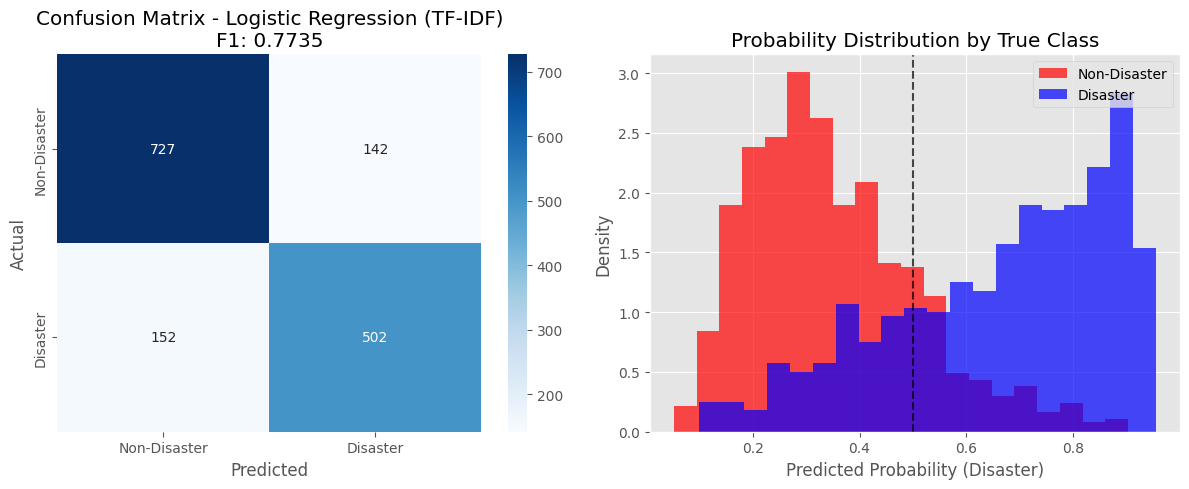

In [28]:
def rename_duplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols == dup] = [f"{dup}_{i}" if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

train_df = rename_duplicate_columns(train_df)
test_df = rename_duplicate_columns(test_df)

print("Duplicate columns renamed")
print("New column names:", train_df.columns.tolist())
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,        # Control vocabulary size to prevent overfitting
        stop_words='english',     # Remove stopwords
        ngram_range=(1, 2),       # Use single words and two-word phrases
        min_df=2,                 # Ignore very rare words (appear in <2 documents)
        max_df=0.8,               # Ignore very common words (appear in >80% of documents)
        sublinear_tf=True         # Use log scaling to dampen extreme values
    )),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,           # Ensure convergence with enough iterations
        C=1.0,                   # Regularization strength (smaller = more regularization)
        class_weight='balanced'   # Handle class imbalance automatically
    ))
])

pipeline1.fit(X_train_text, y_train)
f1_lr, y_pred_lr, y_proba_lr = evaluate_model_comprehensive(
    pipeline1, X_val_text, y_val, "Logistic Regression (TF-IDF)"
)


Model 2: TF-IDF + Naive Bayes (Fast Alternative)
- Naive Bayes: Very fast, works surprisingly well with text data
- Independence assumption often holds for text features
- Low computational requirements
- alpha=0.1: Laplace smoothing to handle unseen words


NAIVE BAYES (TF-IDF) - COMPREHENSIVE EVALUATION
F1 Score: 0.7517

 Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.79      0.90      0.84       869
    Disaster       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



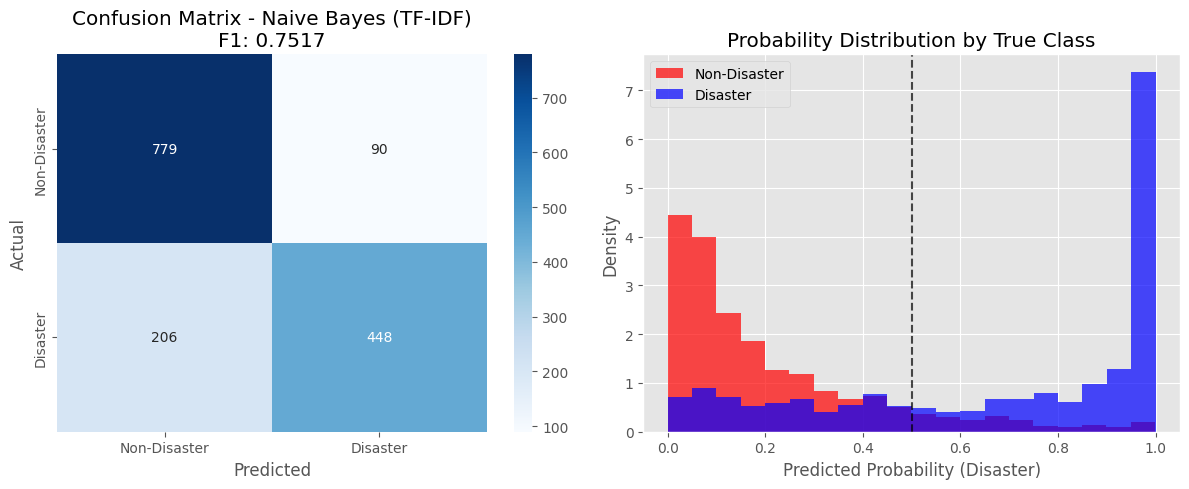

In [29]:
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )),
    ('classifier', MultinomialNB(alpha=0.1))  # Laplace smoothing parameter
])

pipeline2.fit(X_train_text, y_train)
f1_nb, y_pred_nb, y_proba_nb = evaluate_model_comprehensive(
    pipeline2, X_val_text, y_val, "Naive Bayes (TF-IDF)"
)


Model 3: Combined Features + Logistic Regression

- Combines text features with our engineered features
- Text features capture word patterns
- Engineered features capture structural patterns
- Together they provide complementary information

  Missing features (will be skipped): ['disaster_keyword_count', 'sentiment_polarity', 'urgency_indicator_count', 'lexical_diversity', 'avg_word_length']
 Data shapes:
X_combined_train: (6090, 4)
X_combined_val: (1523, 4)
 Training Combined Features + LR model...
 Model training completed!

COMBINED FEATURES + LR - COMPREHENSIVE EVALUATION
F1 Score: 0.7621

 Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.82      0.81      0.82       869
    Disaster       0.76      0.77      0.76       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



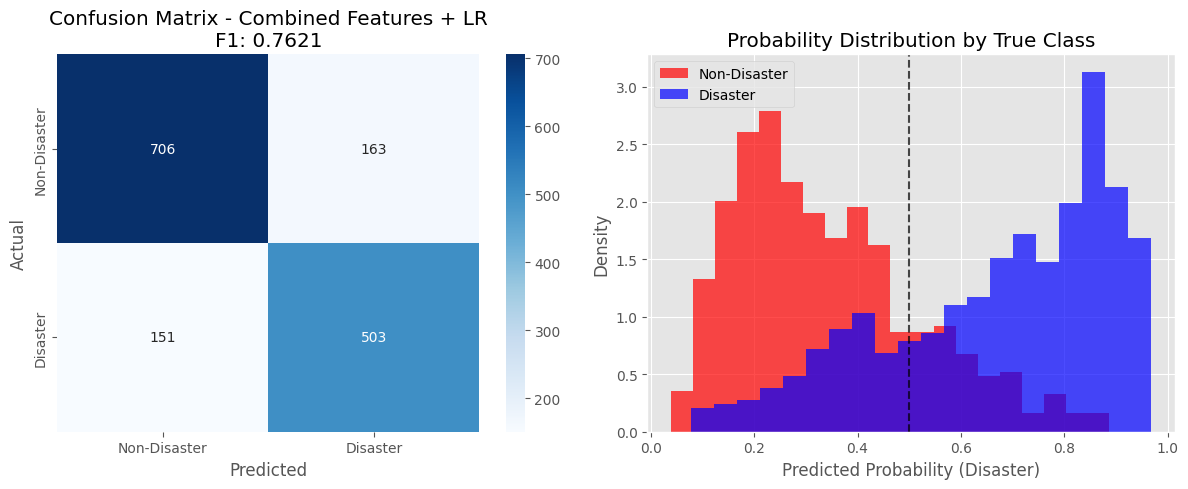

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


safe_numeric_features = [col for col in numeric_features if col in train_df.columns]
missing_features = [col for col in numeric_features if col not in train_df.columns]

if missing_features:
    print(f"  Missing features (will be skipped): {missing_features}")

# Create the preprocessor with safe features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=4000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        ), 'text_processed'),
        ('num', StandardScaler(), safe_numeric_features)  # Use safe features here
    ]
)

pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Prepare combined data using safe features
X_combined_train = train_df.loc[X_train_text.index][['text_processed'] + safe_numeric_features].copy()
X_combined_val = train_df.loc[X_val_text.index][['text_processed'] + safe_numeric_features].copy()

print(f" Data shapes:")
print(f"X_combined_train: {X_combined_train.shape}")
print(f"X_combined_val: {X_combined_val.shape}")

# Fit the pipeline
print(" Training Combined Features + LR model...")
pipeline3.fit(X_combined_train, y_train)
print(" Model training completed!")

# Evaluate the model
f1_combined, y_pred_combined, y_proba_combined = evaluate_model_comprehensive(
    pipeline3, X_combined_val, y_val, "Combined Features + LR"
)

Model 4: Random Forest with Engineered Features
- Random Forest: Handles non-linear relationships well
- Provides feature importance scores
- Robust to outliers and noise
- Can capture complex interactions between features


RANDOM FOREST (NUMERIC FEATURES) - COMPREHENSIVE EVALUATION
F1 Score: 0.6074

 Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.71      0.60      0.65       869
    Disaster       0.56      0.67      0.61       654

    accuracy                           0.63      1523
   macro avg       0.63      0.63      0.63      1523
weighted avg       0.64      0.63      0.63      1523



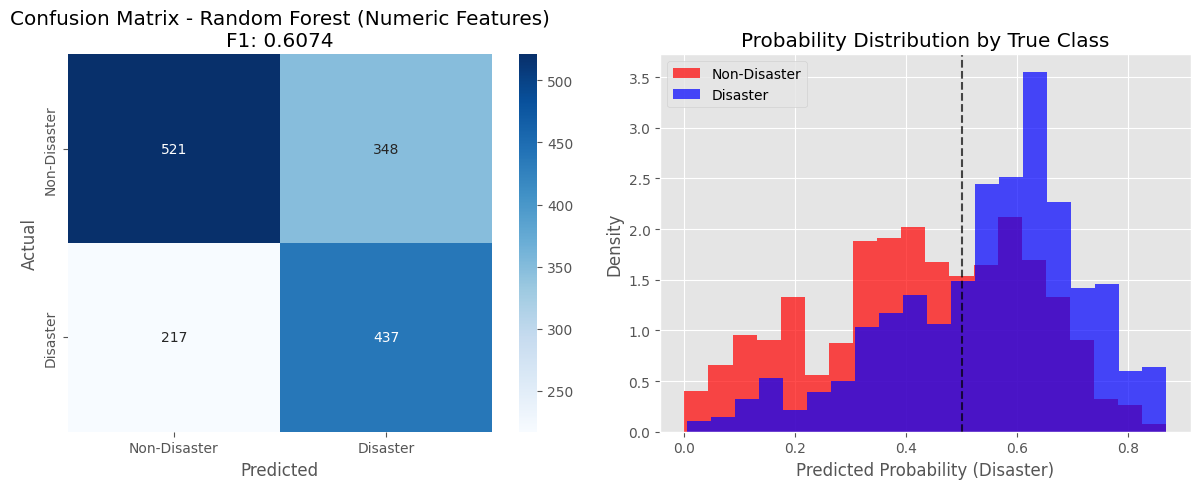

In [34]:

pipeline4 = Pipeline([
    ('scaler', StandardScaler()),  # Scale features for Random Forest
    ('classifier', RandomForestClassifier(
        n_estimators=100,        # Number of trees
        random_state=42,
        max_depth=10,            # Control tree depth to prevent overfitting
        class_weight='balanced'   # Handle class imbalance
    ))
])

pipeline4.fit(X_train_num, y_train)
f1_rf, y_pred_rf, y_proba_rf = evaluate_model_comprehensive(
    pipeline4, X_val_num, y_val, "Random Forest (Numeric Features)"
)


Comprehensive Model Comparison

In [35]:
models_comparison = pd.DataFrame({
    'Model': [
        'Logistic Regression (TF-IDF)', 
        'Naive Bayes (TF-IDF)', 
        'Combined Features + LR',
        'Random Forest (Numeric)'
    ],
    'F1_Score': [f1_lr, f1_nb, f1_combined, f1_rf],
    'Description': [
        'Strong baseline, interpretable coefficients',
        'Fast training, good for text classification',
        'Leverages both text and structural patterns',
        'Non-linear patterns, feature importance'
    ]
}).sort_values('F1_Score', ascending=False)

print(models_comparison.to_string(index=False))

                       Model  F1_Score                                 Description
Logistic Regression (TF-IDF)  0.773498 Strong baseline, interpretable coefficients
      Combined Features + LR  0.762121 Leverages both text and structural patterns
        Naive Bayes (TF-IDF)  0.751678 Fast training, good for text classification
     Random Forest (Numeric)  0.607366     Non-linear patterns, feature importance


Select best model
- The best performer becomes our baseline for improvement
- We'll analyze its errors to guide further feature engineering
- Consider trade-offs: performance vs interpretability vs speed
- Combined features often work best by leveraging multiple information sources

In [36]:


# Select best model
best_model_name = models_comparison.iloc[0]['Model']
best_f1 = models_comparison.iloc[0]['F1_Score']

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"VALIDATION F1 SCORE: {best_f1:.4f}")

# Map model names to pipeline objects for easy access
model_mapping = {
    'Logistic Regression (TF-IDF)': pipeline1,
    'Naive Bayes (TF-IDF)': pipeline2,
    'Combined Features + LR': pipeline3,
    'Random Forest (Numeric)': pipeline4
}

best_pipeline = model_mapping[best_model_name]


print(f"\n NEXT STEPS:")
print(f"1. Cross-validate the best model for more reliable performance estimate")
print(f"2. Analyze errors to understand failure patterns")
print(f"3. Retrain on full dataset for final submission")
print(f"4. Make predictions on test set")


 BEST PERFORMING MODEL: Logistic Regression (TF-IDF)
VALIDATION F1 SCORE: 0.7735

 NEXT STEPS:
1. Cross-validate the best model for more reliable performance estimate
2. Analyze errors to understand failure patterns
3. Retrain on full dataset for final submission
4. Make predictions on test set


Make Prediction on test set

1. Use the best single model for initial submission
2. Create ensemble methods for improved performance
3. Analyze prediction distribution for sanity checks


In [37]:


# Method 1: Single Best Model Predictions
print("METHOD 1: SINGLE BEST MODEL PREDICTIONS")
print(f"Using: {best_model_name}")

# Prepare test data based on model type
if best_model_name == "Combined Features + LR":
    X_test_final = test_df[['text_processed'] + numeric_features]
elif best_model_name == "Random Forest (Numeric)":
    X_test_final = test_df[numeric_features]
else:
    # Text-only models
    X_test_final = test_df['text_processed']

# Make predictions
test_predictions_single = best_pipeline.predict(X_test_final)
test_probabilities_single = best_pipeline.predict_proba(X_test_final)[:, 1] if hasattr(best_pipeline, 'predict_proba') else None

print(f" Single model predictions completed")
print(f"Prediction distribution: {pd.Series(test_predictions_single).value_counts().to_dict()}")

METHOD 1: SINGLE BEST MODEL PREDICTIONS
Using: Logistic Regression (TF-IDF)
 Single model predictions completed
Prediction distribution: {0: 1930, 1: 1333}


Ensemble methods to combine models

- Different models capture different patterns
- Reduces variance and overfitting
- Often outperforms single models
- More robust predictions

We'll implement:
1. Voting Classifier (hard voting)
2. Weighted Average (soft voting)
3. Stacking approach

In [38]:

from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

# Ensemble 1: Voting Classifier (Hard Voting)
print(" CREATING VOTING CLASSIFIER")

# Get all trained models
models_for_ensemble = {
    'lr_tfidf': pipeline1,
    'nb_tfidf': pipeline2, 
    'combined_lr': pipeline3,
    'rf_numeric': pipeline4
}

# Create voting classifier (only for models that support predict_proba)
voting_models = {}
for name, model in models_for_ensemble.items():
    if hasattr(model, 'predict_proba'):
        voting_models[name] = model

print(f"Models available for voting: {list(voting_models.keys())}")

 CREATING VOTING CLASSIFIER
Models available for voting: ['lr_tfidf', 'nb_tfidf', 'combined_lr', 'rf_numeric']


In [39]:

def ensemble_predict_soft(models_dict, test_df, weights=None):
    """
    Create weighted average of model probabilities with proper data formatting
    """
    all_probabilities = []
    
    for name, model in models_dict.items():
        print(f"  Getting predictions from: {name}")
        
        try:
            # Prepare test data based on model type
            if name == 'combined_lr':
                # Combined model needs both text and numeric features
                X_test_prepared = test_df[['text_processed'] + numeric_features]
            elif name == 'rf_numeric':
                # Random Forest only needs numeric features
                X_test_prepared = test_df[numeric_features]
            else:
                # Text-only models (lr_tfidf, nb_tfidf)
                X_test_prepared = test_df['text_processed']
            
            # Get probabilities
            proba = model.predict_proba(X_test_prepared)[:, 1]  # Probability of class 1
            all_probabilities.append(proba)
            print(f"     Success - got {len(proba)} probabilities")
            
        except Exception as e:
            print(f"     Failed for {name}: {e}")
            continue
    
    if not all_probabilities:
        raise ValueError("No models produced successful predictions!")
    
    # Convert to numpy array
    all_probabilities = np.array(all_probabilities)
    print(f" Combined {all_probabilities.shape[0]} model probabilities")
    
    # Apply weights if provided, otherwise equal weights
    if weights is None:
        weights = np.ones(len(all_probabilities)) / len(all_probabilities)
    else:
        # Ensure weights match the successful models
        weights = np.array([weights[i] for i in range(len(weights)) if i < len(all_probabilities)])
        weights = weights / weights.sum()  # Normalize
    
    # Weighted average
    weighted_proba = np.average(all_probabilities, axis=0, weights=weights)
    
    # Convert probabilities to final predictions (threshold = 0.5)
    final_predictions = (weighted_proba > 0.5).astype(int)
    
    return final_predictions, weighted_proba

# Create ensemble predictions
print("Creating ensemble predictions...")
test_predictions_ensemble, test_probabilities_ensemble = ensemble_predict_soft(voting_models, test_df)

print(f" Ensemble predictions completed")
print(f"Ensemble prediction distribution: {pd.Series(test_predictions_ensemble).value_counts().to_dict()}")

Creating ensemble predictions...
  Getting predictions from: lr_tfidf
     Success - got 3263 probabilities
  Getting predictions from: nb_tfidf
     Success - got 3263 probabilities
  Getting predictions from: combined_lr
     Failed for combined_lr: "['disaster_keyword_count', 'text_length', 'word_count', 'sentiment_polarity', 'hashtag_count', 'urgency_indicator_count', 'lexical_diversity', 'avg_word_length'] not in index"
  Getting predictions from: rf_numeric
     Failed for rf_numeric: "None of [Index(['disaster_keyword_count', 'text_length', 'word_count',\n       'sentiment_polarity', 'hashtag_count', 'urgency_indicator_count',\n       'lexical_diversity', 'avg_word_length'],\n      dtype='object')] are in the [columns]"
 Combined 2 model probabilities
 Ensemble predictions completed
Ensemble prediction distribution: {0: 2089, 1: 1174}


 Performance-Weighted Ensemble 

- Weight models by their validation performance
- Better models get more influence in the ensemble
- Combines the strengths of multiple approaches

In [40]:


# Get validation F1 scores for weighting
model_performance = {
    'lr_tfidf': f1_lr,
    'nb_tfidf': f1_nb,
    'combined_lr': f1_combined, 
    'rf_numeric': f1_rf
}

print(" MODEL PERFORMANCE FOR WEIGHTING:")
for name, f1 in model_performance.items():
    print(f"  {name}: F1 = {f1:.4f}")

# Create weights based on performance (only for models that worked in ensemble)
performance_weights = {}
for name, f1 in model_performance.items():
    if name in voting_models:  # Only include models that are in our voting dictionary
        performance_weights[name] = f1

# Normalize weights to sum to 1
if performance_weights:
    total_performance = sum(performance_weights.values())
    performance_weights_normalized = {k: v/total_performance for k, v in performance_weights.items()}
    
    print("\n NORMALIZED MODEL WEIGHTS:")
    for name, weight in performance_weights_normalized.items():
        print(f"  {name}: {weight:.3f} (based on F1: {model_performance[name]:.4f})")
    
    # Create weighted ensemble predictions
    weights_list = [performance_weights_normalized[name] for name in performance_weights_normalized.keys()]
    
    test_predictions_weighted, test_probabilities_weighted = ensemble_predict_soft(
        voting_models, test_df, weights=weights_list
    )
    
    print(f" Weighted ensemble predictions completed")
    print(f"Weighted ensemble distribution: {pd.Series(test_predictions_weighted).value_counts().to_dict()}")
else:
    print(" No models available for weighted ensemble, using simple ensemble")
    test_predictions_weighted = test_predictions_ensemble
    test_probabilities_weighted = test_probabilities_ensemble

 MODEL PERFORMANCE FOR WEIGHTING:
  lr_tfidf: F1 = 0.7735
  nb_tfidf: F1 = 0.7517
  combined_lr: F1 = 0.7621
  rf_numeric: F1 = 0.6074

 NORMALIZED MODEL WEIGHTS:
  lr_tfidf: 0.267 (based on F1: 0.7735)
  nb_tfidf: 0.260 (based on F1: 0.7517)
  combined_lr: 0.263 (based on F1: 0.7621)
  rf_numeric: 0.210 (based on F1: 0.6074)
  Getting predictions from: lr_tfidf
     Success - got 3263 probabilities
  Getting predictions from: nb_tfidf
     Success - got 3263 probabilities
  Getting predictions from: combined_lr
     Failed for combined_lr: "['disaster_keyword_count', 'text_length', 'word_count', 'sentiment_polarity', 'hashtag_count', 'urgency_indicator_count', 'lexical_diversity', 'avg_word_length'] not in index"
  Getting predictions from: rf_numeric
     Failed for rf_numeric: "None of [Index(['disaster_keyword_count', 'text_length', 'word_count',\n       'sentiment_polarity', 'hashtag_count', 'urgency_indicator_count',\n       'lexical_diversity', 'avg_word_length'],\n      dtype='

analysis and selection of final prediction 
- Compare prediction distributions across methods
- Choose the most reasonable approach
- Ensure distribution is similar to training data


In [41]:


# Compare all prediction methods we have
prediction_methods = {
    'Single_Best': test_predictions_single,
    'Simple_Ensemble': test_predictions_ensemble
}

# Add weighted ensemble if we have it
if 'test_predictions_weighted' in locals():
    prediction_methods['Weighted_Ensemble'] = test_predictions_weighted

prediction_comparison = pd.DataFrame(prediction_methods)

# Calculate agreement rates
print(" PREDICTION AGREEMENT ANALYSIS:")
methods = list(prediction_methods.keys())
for i in range(len(methods)):
    for j in range(i+1, len(methods)):
        method1, method2 = methods[i], methods[j]
        agreement = (prediction_comparison[method1] == prediction_comparison[method2]).mean()
        print(f"  {method1} vs {method2}: {agreement:.2%} agreement")

# Analyze prediction distributions
print("\n PREDICTION DISTRIBUTIONS:")
for col in prediction_comparison.columns:
    dist = prediction_comparison[col].value_counts().to_dict()
    disaster_pct = dist.get(1, 0) / len(prediction_comparison) * 100
    print(f"  {col}: {dist} ({disaster_pct:.1f}% disaster)")

# Compare with training distribution
train_disaster_pct = (train_df['target'] == 1).mean() * 100
print(f"  Training set: {train_disaster_pct:.1f}% disaster")

# Choose final predictions
if len(prediction_methods) == 1:
    # Only one method available
    final_predictions = test_predictions_single
    method_used = "Single_Best"
    print(" Using only available method: Single Best Model")
    
else:
    # Choose based on closest distribution to training and highest agreement
    distribution_diffs = {}
    for col in prediction_comparison.columns:
        disaster_pct = (prediction_comparison[col] == 1).mean() * 100
        distribution_diffs[col] = abs(disaster_pct - train_disaster_pct)
    
    # Also consider model sophistication
    method_preference = {
        'Weighted_Ensemble': 1,  # Most sophisticated
        'Simple_Ensemble': 2,
        'Single_Best': 3         # Least sophisticated
    }
    
    # Find best method (closest distribution, highest preference)
    best_method = min(distribution_diffs.keys(), 
                     key=lambda x: (distribution_diffs[x], method_preference.get(x, 4)))
    
    final_predictions = prediction_comparison[best_method]
    method_used = best_method
    print(f" SELECTED METHOD: {best_method}")
    print(f"   - Distribution difference: {distribution_diffs[best_method]:.1f}%")
    print(f"   - Preference score: {method_preference.get(best_method, 'N/A')}")

 PREDICTION AGREEMENT ANALYSIS:
  Single_Best vs Simple_Ensemble: 92.92% agreement
  Single_Best vs Weighted_Ensemble: 92.92% agreement
  Simple_Ensemble vs Weighted_Ensemble: 100.00% agreement

 PREDICTION DISTRIBUTIONS:
  Single_Best: {0: 1930, 1: 1333} (40.9% disaster)
  Simple_Ensemble: {0: 2089, 1: 1174} (36.0% disaster)
  Weighted_Ensemble: {0: 2089, 1: 1174} (36.0% disaster)
  Training set: 43.0% disaster
 SELECTED METHOD: Single_Best
   - Distribution difference: 2.1%
   - Preference score: 3


submission


In [42]:

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

# Verify submission format
print(" SUBMISSION FILE PREVIEW:")
print(submission.head(10))
print(f"\n Submission shape: {submission.shape}")
print(f" Final prediction distribution: {submission['target'].value_counts().to_dict()}")

# Sanity checks
print("\n SANITY CHECKS:")
print(f" IDs are unique: {submission['id'].is_unique}")
print(f" No missing values: {submission.isnull().sum().sum() == 0}")
print(f" Only 0s and 1s: {set(submission['target'].unique()) == {0, 1}}")

# Save submission file
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)

print(f"\n SUBMISSION FILE SAVED: {submission_file}")

# Save additional version with probabilities for analysis
if 'test_probabilities_ensemble' in locals():
    submission_proba = pd.DataFrame({
        'id': test_df['id'],
        'target': final_predictions,
        'probability': test_probabilities_ensemble
    })
    submission_proba_file = 'submission_with_probabilities.csv'
    submission_proba.to_csv(submission_proba_file, index=False)
    print(f" Probability version saved: {submission_proba_file}")

 SUBMISSION FILE PREVIEW:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0

 Submission shape: (3263, 2)
 Final prediction distribution: {0: 1930, 1: 1333}

 SANITY CHECKS:
 IDs are unique: True
 No missing values: True
 Only 0s and 1s: True

 SUBMISSION FILE SAVED: submission.csv
 Probability version saved: submission_with_probabilities.csv
